In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
save_path = '/content/drive/MyDrive/RiceDeepMLFinalProjectTrainingModels'

if(os.path.exists(save_path)):
  print("Path exists")
else:
  print("Path does not exist")

Path exists


In [ ]:

!pip install -q kaggle

# Standard imports
import os, json, shutil, time
from pathlib import Path
from PIL import Image
import numpy as np
from tqdm import tqdm
import imageio
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (Dense, Reshape, LeakyReLU, Conv2D,
                                     Conv2DTranspose, Flatten, Dropout,
                                     BatchNormalization)


In [ ]:


os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
kaggle_json_path = os.path.expanduser("~/.kaggle/kaggle.json")

creds = {"username":"RandomHuman003", "key":"KGAT_44e9e9c89859fb119cf9fb9a48277cd9"}
with open(kaggle_json_path, "w") as f:
    json.dump(creds, f)
os.chmod(kaggle_json_path, 0o600)


!kaggle datasets download -d jessicali9530/celeba-dataset -q
!unzip -o celeba-dataset.zip -d celeba_data


Streaming output truncated to the last 5000 lines.
  inflating: celeba_data/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: celeba_data/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: celeba_data/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: celeba_data/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: celeba_data/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: celeba_data/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: celeba_data/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: celeba_data/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: celeba_data/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: celeba_data/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: celeba_data/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: celeba_data/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: celeba_data/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: 

In [ ]:
# Constants
PIC_DIR = "celeba_data/img_align_celeba/img_align_celeba/"
IMG_SIZE = 128
BATCH_SIZE = 64
LATENT_DIM = 32
EPOCHS = 20
RES_DIR = "res2"
FILE_PATH = os.path.join(RES_DIR, "generated_%03d.png")
os.makedirs(RES_DIR, exist_ok=True)

# Build a tf.data pipeline that reads files from disk lazily
AUTOTUNE = tf.data.AUTOTUNE

def _load_and_preprocess(path):
    """Read a JPEG from path, decode, resize and normalize to [-1, 1]."""
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = (img / 127.5) - 1.0   # map to [-1,1]
    return img

# Get list of image files
filenames = tf.io.gfile.glob(os.path.join(PIC_DIR, "*.jpg"))
print("Found", len(filenames), "images")


dataset = (tf.data.Dataset.from_tensor_slices(filenames)
           .shuffle(buffer_size=len(filenames))
           .map(lambda p: _load_and_preprocess(p), num_parallel_calls=AUTOTUNE)
           .batch(BATCH_SIZE, drop_remainder=True)
           .prefetch(AUTOTUNE))


Found 202599 images


In [ ]:
print(len(filenames))

202599


In [ ]:
def build_generator(latent_dim=LATENT_DIM):
    z = Input(shape=(latent_dim,))
    x = Dense(8*8*256, use_bias=False)(z)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Reshape((8, 8, 256))(x)

    x = Conv2DTranspose(128, 5, strides=2, padding="same", use_bias=False)(x)  # 16x16
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2DTranspose(64, 5, strides=2, padding="same", use_bias=False)(x)   # 32x32
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2DTranspose(32, 5, strides=2, padding="same", use_bias=False)(x)   # 64x64
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    if IMG_SIZE == 128:
        x = Conv2DTranspose(16, 5, strides=2, padding="same", use_bias=False)(x) # 128x128
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

    out = Conv2DTranspose(3, 5, strides=1, padding="same", activation="tanh")(x)  # final [-1,1]
    return Model(z, out, name="generator")

generator = build_generator()
generator.summary()


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16384)          │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16384)          │        65,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 16, 16, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 32, 32, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 64, 64, 32)     │        51,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 128, 128, 16)   │        12,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 128, 128, 3)    │         1,203 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,679,987 (6.41 MB)

 Trainable params: 1,646,739 (6.28 MB)

 Non-trainable params: 33,248 (129.88 KB)

In [ ]:
def build_discriminator(img_size=IMG_SIZE):
    img_in = Input(shape=(img_size, img_size, 3))
    x = Conv2D(64, 5, strides=2, padding="same")(img_in)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, 5, strides=2, padding="same")(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, 5, strides=2, padding="same")(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    out = Dense(1)(x)
    return Model(img_in, out, name="discriminator")

discriminator = build_discriminator()
discriminator.summary()


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │        65,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,094,785 (4.18 MB)

 Trainable params: 1,094,785 (4.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_logits, fake_logits):
    real_loss = cross_entropy(tf.ones_like(real_logits), real_logits)
    fake_loss = cross_entropy(tf.zeros_like(fake_logits), fake_logits)
    return real_loss + fake_loss

def generator_loss(fake_logits):
    return cross_entropy(tf.ones_like(fake_logits), fake_logits)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [ ]:
from tensorflow.keras.models import load_model

try:
  print('Loading models from drive...')
  generator = load_model(f'{save_path}/generator_epoch_9.h5')
  discriminator = load_model(f'{save_path}/discriminator_epoch_9.h5')
  print('Models loaded successfully')
except Exception as e:
  print('Error loading models from drive')

Loading models from drive...


Models loaded successfully


In [ ]:
# For consistent visualization
seed = tf.random.normal([16, LATENT_DIM])

def train_step(real_images):
    batch_size = real_images.shape[0]

    # Train discriminator on real and fake
    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
        fake_images = generator(noise, training=True)

        real_logits = discriminator(real_images, training=True)
        fake_logits = discriminator(fake_images, training=True)

        d_loss = discriminator_loss(real_logits, fake_logits)
        g_loss = generator_loss(fake_logits)

    d_grads = disc_tape.gradient(d_loss, discriminator.trainable_variables)
    g_grads = gen_tape.gradient(g_loss, generator.trainable_variables)

    discriminator_optimizer.apply_gradients(zip(d_grads, discriminator.trainable_variables))
    generator_optimizer.apply_gradients(zip(g_grads, generator.trainable_variables))

    return g_loss, d_loss


In [ ]:
drive_img_path = os.path.join(save_path, "images", "generated_%03d.png")

In [ ]:
def generate_and_save_images(model, epoch, test_input, file_path=FILE_PATH):
    drive_folder = os.path.dirname(drive_img_path)
    if not os.path.exists(drive_folder):
        os.makedirs(drive_folder)

    predictions = model(test_input, training=False)
    # predictions shape: (N, H, W, 3) with values in [-1,1]
    n = predictions.shape[0]
    fig = plt.figure(figsize=(4,4))
    for i in range(n):
        plt.subplot(4,4,i+1)
        img = (predictions[i].numpy() + 1.0) / 2.0
        plt.imshow(np.clip(img, 0, 1))
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(file_path % epoch)
    plt.savefig(drive_img_path % epoch)
    plt.close(fig)


In [ ]:
import csv

In [ ]:
def train(dataset, epochs):
    g_loss_list = []
    d_loss_list = []

    log_file = f'{save_path}/log.csv'

    if not os.path.exists(log_file):
        with open(log_file, 'w') as f:
          writer = csv.writer(f)
          writer.writerow(['epoch', 'g_loss', 'd_loss'])

    for epoch in range(20, 26):
        print(f"Epoch {epoch}/{25}")
        g_loss_acc = 0.0
        d_loss_acc = 0.0
        steps = 0

        for image_batch in tqdm(dataset):
            g_loss, d_loss = train_step(image_batch)
            # Convert to floats for logging
            g_loss_acc += float(g_loss.numpy())
            d_loss_acc += float(d_loss.numpy())
            steps += 1

        generator.save(f'{save_path}/generator_epoch_{epoch}.h5')
        discriminator.save(f'{save_path}/discriminator_epoch_{epoch}.h5')

        g_loss_list.append(g_loss_acc/steps)
        d_loss_list.append(d_loss_acc/steps)

        # epoch averages
        print(f"Epoch {epoch} - G loss: {g_loss_acc/steps:.4f}, D loss: {d_loss_acc/steps:.4f}")

        # Save sample images (every epoch)
        generate_and_save_images(generator, epoch, seed)

        with open(log_file, 'a', newline = '') as f:
          writer = csv.writer(f)
          writer.writerow([epoch, g_loss_acc/steps, d_loss_acc/steps])

# Start training
train(dataset, EPOCHS)


Epoch 20/25


100%|██████████| 3165/3165 [14:53<00:00,  3.54it/s]


Epoch 20 - G loss: 3.4003, D loss: 0.3559
Epoch 21/25


100%|██████████| 3165/3165 [14:53<00:00,  3.54it/s]


Epoch 21 - G loss: 3.4476, D loss: 0.3499
Epoch 22/25


100%|██████████| 3165/3165 [14:56<00:00,  3.53it/s]


Epoch 22 - G loss: 3.4957, D loss: 0.3445
Epoch 23/25


 62%|██████▏   | 1957/3165 [09:14<05:39,  3.56it/s]

In [ ]:

images = []
for epoch in range(1, EPOCHS+1):
    path = FILE_PATH % epoch
    if os.path.exists(path):
        images.append(imageio.imread(path))
if images:
    imageio.mimsave(os.path.join(RES_DIR, "progress.gif"), images, fps=4)
    print("Saved GIF:", os.path.join(RES_DIR, "progress.gif"))


/tmp/ipython-input-631793197.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(path))


Saved GIF: res2/progress.gif


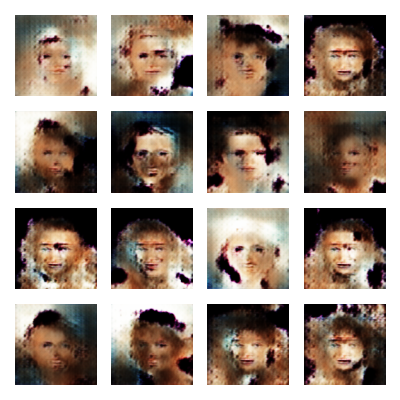

In [ ]:
import imageio
from IPython.display import Image, display

latest_path = FILE_PATH % EPOCHS

if os.path.exists(latest_path):
    display(Image(filename=latest_path))
else:
    print("Image not found:", latest_path)
